<a href="https://colab.research.google.com/github/trista-paul/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600) #uniform dist
  purchased = random.random() < 0.1 + (time_on_site // 1500) #random 0-1 float is in threshold of 10% base probability + its 1% increment after every 15 seconds 
  users.append(User(purchased, time_on_site, False)) #adds the user just given a random float to the list 'users'
  
for _ in range(750): #mobile users has more weight
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
#both groups can be in (10,300)
random.shuffle(users)
print(users[:10])

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

In [0]:
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')
#normalize makes the counts into percentages

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

# Don's suggestion - three dimensional crosstab that adds (x,y) categories
a= time_bins
b = user_data['purchased']
c = user_data['mobile']
pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'],
            normalize = 'index')

In [0]:
#Mac' suggestion - seperate the dataframes and get descriptive stats by bin
#This is like what I had to do to graph the seperate flower classes yesterday, but nicer code
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series
for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

In [0]:
#Cole's histograms seperated by device
user_data.[user_data['mobile'] == True].plot.density()
user_data.[user_data['mobile'] == False].plot.density()

In [0]:
#Aaron's crosstab and plot
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                        normalize='columns')
ct.plot(kind='bar') #probability a (purchased, mobile) type
                    #will spend a certain amount of time
#frame plot method; crosstab is a dataframe and can be graphed directly
ct2 = pd.crosstab(user_data['purchased'], [user_data['mobile'], time_bins],
                  normalize='columns')
ct2.plot(kind='bar') #I liked the effect but we decided it had too many dimensions

In [0]:
#Chris' groupby - Try ensuring the mobile bin stops at 300 seconds
#groupby objects is like group in SQL - is chunking userdata by sprcified group
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()

In [0]:
#Cole's 3d histogram - Mobile var in red, Purchase var in blue
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

In [0]:
#Some vocabulary from lecture
#conversion = desired outcome
#dimensions = x variables
#Simpson's Paradox - the data can present a completely different story
#depending on which confounders are considered
#the famous example is it turned out the female applicants to UC Berkeley,
#whose admittance rate appeared to be 10% lower than men
#were applying for harder programs than men
#"The takeaway of this lecture is to not automatically trust bivariate graphs"

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [12]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv',
                index_col=0)
df.head(5)
df.info() #all are int64
df.corr()
#largest is an inverse relationship between weight/excersize time, which seems true
#inverse age/time could be confounded by having work, health problems, and is a smaller corr
#and positive age/weight is confounded by ex time

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 3 columns):
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(3)
memory usage: 37.5 KB


,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


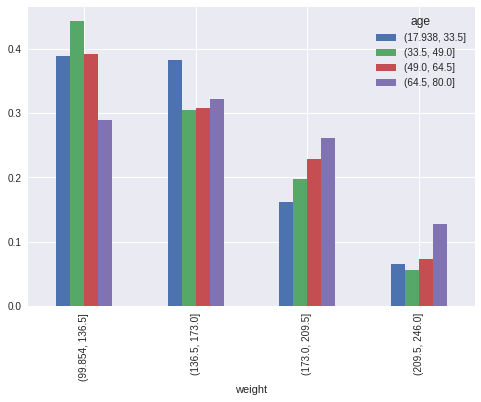

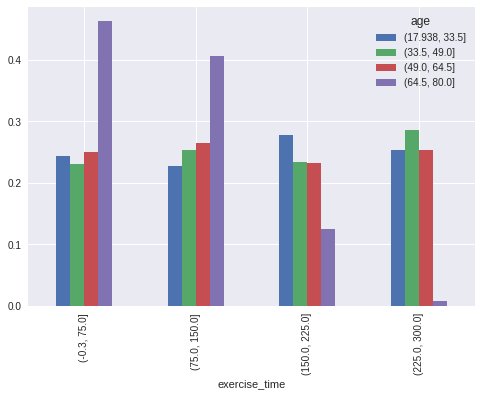

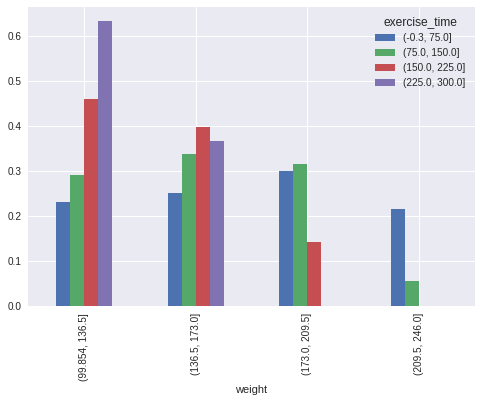

In [52]:
age_bins = pd.cut(df['age'], 4)
weight_bins = pd.cut(df['weight'], 4)
time_bins = pd.cut(df['exercise_time'], 4)
#weight and age
ct1 = pd.crosstab(weight_bins, age_bins, normalize='columns')
print(ct1.plot(kind = 'bar')) #p a person of certain age has a certain weight
#it appears to generally worsen with age

#ex.time and age
ct2 = pd.crosstab(time_bins, age_bins, normalize='columns')
print(ct2.plot(kind = 'bar')) #p a person of certain age has a certain ex time
#slightly negative. Elders are far more likely to never excersize and nearly never have heavy excersize

#weight and ex.time
ct3 = pd.crosstab(weight_bins, time_bins, normalize = 'columns')
print(ct3.plot(kind='bar'))#p a person of certain weight has a certain ex time
#appears to strongly effect likelihood

#weight appears to rise with age when ex time lowers.

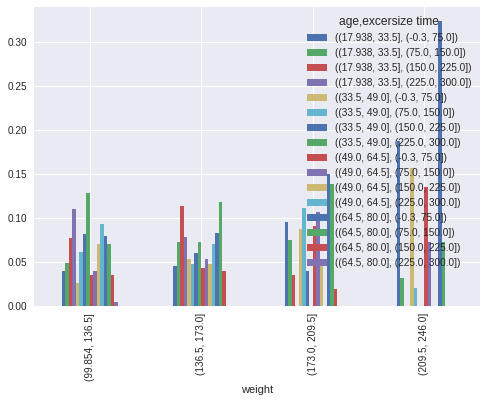

In [51]:
#ex. weight by time and age
ct = pd.crosstab(weight_bins, [age_bins, time_bins], rownames=['weight'], colnames=['age', 'excersize time'],
            normalize = 'index') #many are 0.00 corr even after I lowered the number of bins
                                 #its rare to see a corr above 10%
ct.plot(kind = 'bar') #p a person of certain age and ex time has a certain weight

#elders who excersize little are the most likely group to be overweight, and it shoots down dramatically when they move to the next level of excersize
#this pattern appears in all age groups


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
**All three values are integers.**
2.  What are the relationships between the variables?
**Age and weight: positive**
**Age and ex time: negative**
**Weight and ex time: negative**
3.  Which relationships are "real", and which spurious? **The relationship between excersize time and weight is real. The relationship between weight and age is confounded by older people being less likely to excersize.**


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)